In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [2]:
from functools import partial

import numpy as np
import pandas as pd
from IPython.display import display

import bundle
import features as F
import selection
import utils as U
from dataset import load, load_sample, Subset
from encode import encode
from training import train, inference, submit
from meta import compute_meta_data
from metric import optimize_rounding_bounds, RegressionCappa

In [3]:
sample = False
if U.on_kaggle():
    U.log('Loading test set only.')
    tst_data = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
else:
    if sample:
        U.log('Warning: loading train and test data sample.')
        trn_data, _, _ = load_sample(Subset.Train, 500_000)
        [tst_data] = load_sample(Subset.Test, 500_000)
    else:
        U.log('Loading train and test.')
        trn_data, trn_spec, trn_targ = load(Subset.Train)
        [tst_data] = load(Subset.Test)

Loading train and test.
(11341042, 11) (17690, 7) (386, 3) (1156414, 11) 

## Preparing

In [5]:
transform = U.combine(
    partial(F.add_feature_combinations, pairs=[('title', 'event_code')]),
    partial(F.add_datetime, column='timestamp', prefix='ts'),
    partial(F.add_cyclical, prefix='ts')
)

if U.on_kaggle():
    U.log('Transforming test data only.')
    X_tst = transform(tst_data.copy())
    U.log(X_tst.shape)
else:
    U.log('Transforming train and test data.')
    X_tst = transform(tst_data.copy())
    X_trn = transform(trn_data.copy())
    U.log(X_trn.shape, X_tst.shape)

Transforming train and test data.
(11341042, 31) (1156414, 31)


In [6]:
if U.on_kaggle():
    U.log('Reading pre-computed meta from disk.')
    meta = bundle.meta()
else:
    U.log('Computing meta using train and test datasets.')
    meta = compute_meta_data(X_trn, X_tst)
    U.log('Saving computed meta on disk.')
    bundle.save_meta(meta, 'meta')

Computing meta using train and test datasets.
Saving computed meta on disk.


In [7]:
extractor = F.FeaturesExtractor([
    F.CountingFeatures(meta),
    F.PerformanceFeatures(meta),
    F.CyclicFeatures(meta),
    F.TimestampFeatures(meta),
    F.VarietyFeatures(meta),
    F.EventDataFeatures(meta)
])

algo = F.InMemoryAlgorithm(extractor, meta, num_workers=12)

cat_cols = ['session_title']

if U.on_kaggle():
    U.log('Preparing test dataset.')
    X_tst = algo.run(X_tst, test=True)
    encoders = bundle.encoders()
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
else:
    U.log('Preparing train and test datasets.')
    X_trn = algo.run(X_trn)
    X_tst = algo.run(X_tst, test=True)
    X_trn, encoders = encode(X_trn, cat_cols)
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
    bundle.save(encoders, 'encoders')

Preparing train and test datasets.
Running algorithm in train mode.



Running algorithm in test mode.


In [8]:
if U.on_kaggle():
    U.log('Running post-processing on test set only.')
    F.add_user_wise_features(X_tst, meta)
else:
    U.log('Running post-processing on train and test sets.')
    F.add_user_wise_features(X_trn, meta)
    F.add_user_wise_features(X_tst, meta)

Running post-processing on train and test sets.


## Experiments

In [15]:
# features from event_data
# https://www.kaggle.com/c/data-science-bowl-2019/discussion/124028

# truncated validation
# https://www.kaggle.com/ragnar123/truncated-val
# https://www.kaggle.com/c/data-science-bowl-2019/discussion/120790

# def eval_qwk_lgb_regr(y_pred, train_t):
#     """
#     Fast cappa eval function for lgb.
#     """
#     dist = Counter(train_t['accuracy_group'])
#     for k in dist:
#         dist[k] /= len(train_t)
    
#     acum = 0
#     bound = {}
#     for i in range(3):
#         acum += dist[i]
#         bound[i] = np.percentile(y_pred, acum * 100)

#     def classify(x):
#         if x <= bound[0]:
#             return 0
#         elif x <= bound[1]:
#             return 1
#         elif x <= bound[2]:
#             return 2
#         else:
#             return 3

#     y_pred = np.array(list(map(classify, y_pred)))
    
#     return y_pred

# from sklearn.metrics import cohen_kappa_score, mean_squared_error

#     params = {'boosting_type': 'gbdt', 
#               'metric': 'rmse', 
#               'objective': 'regression', 
#               'eval_metric': 'cappa', 
#               'n_jobs': -1, 
#               'seed': 42, 
#               'num_leaves': 26, 
#               'learning_rate': 0.077439684887749, 
#               'max_depth': 33, 
#               'lambda_l1': 3.27791989030057, 
#               'lambda_l2': 1.3047627805931334, 
#               'bagging_fraction': 0.896924978584253, 
#               'bagging_freq': 1, 
#               'colsample_bytree': 0.8710772167017853}

# https://www.kaggle.com/braquino/convert-to-regression

In [10]:
def match_cols(cols, regex):
    import re
    return [col for col in cols if re.match(regex, col)]
def starts_with(cols, prefix): 
    return match_cols(cols, f'^{prefix}')

In [11]:
from collections import OrderedDict

columns = X_trn.columns.tolist()
cnt_cols = starts_with(columns, 'cnt_')
perf_cols = starts_with(columns, 'perf_')
var_cols = starts_with(columns, 'var_')
user_cols = starts_with(columns, 'user_')
ts_cols = starts_with(columns, 'ts_')
event_cols = starts_with(columns, 'event_')
cols = cnt_cols + perf_cols + var_cols + user_cols + ts_cols + event_cols

features_groups = [
    ('all', cols),
    ('cnt', cnt_cols),
    ('perf', perf_cols),
    ('var', var_cols),
    ('user', user_cols),
    ('ts', ts_cols),
    ('cnt+perf', cnt_cols + perf_cols),
    ('cnt+var', cnt_cols + var_cols),
    ('cnt+ts', cnt_cols + ts_cols),
    ('perf+var', perf_cols + var_cols),
    ('perf+ts', perf_cols + ts_cols),
    ('cnt+user', cnt_cols + user_cols),
    ('cnt+perf+var', cnt_cols + perf_cols + var_cols),
    ('cnt+perf+user', cnt_cols + perf_cols + user_cols),
    ('cnt+perf+user+var', cnt_cols + perf_cols + user_cols + var_cols),
    ('event', event_cols),
    ('event+cnt', event_cols + cnt_cols),
    ('event+cnt+perf', event_cols + cnt_cols + perf_cols),
    ('event+cnt+perf+user', event_cols + cnt_cols + perf_cols + user_cols),
    ('event+cnt+perf+var', event_cols + cnt_cols + perf_cols + var_cols),
    ('event+cnt+perf+user+var', event_cols + cnt_cols + perf_cols + user_cols + var_cols),
]

In [12]:
results = []
for col_group, features in features_groups:
    U.log(f'Training columns group: {col_group}')
    reg_metric = RegressionCappa([-np.inf, 1., 2., 3., +np.inf])
    result = train(X_trn, features, reg_metric, algo='lightgbm')
    opt_bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
    reg_metric = RegressionCappa(opt_bounds)
    result = train(X_trn, features, reg_metric, algo='lightgbm')
    results.append((col_group, result))

Training columns group: all
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13623	trn's cappa: 0.240703	val's rmse: 1.168	val's cappa: 0.209886
[200]	trn's rmse: 1.08026	trn's cappa: 0.309819	val's rmse: 1.13856	val's cappa: 0.233777
[300]	trn's rmse: 1.04169	trn's cappa: 0.362431	val's rmse: 1.12377	val's cappa: 0.256964
[400]	trn's rmse: 1.01175	trn's cappa: 0.399207	val's rmse: 1.11493	val's cappa: 0.271222
[500]	trn's rmse: 0.98694	trn's cappa: 0.424395	val's rmse: 1.11036	val's cappa: 0.280173
[600]	trn's rmse: 0.965244	trn's cappa: 0.445411	val's rmse: 1.10806	val's cappa: 0.28409
[700]	trn's rmse: 0.945693	trn's cappa: 0.464077	val's rmse: 1.10678	val's cappa: 0.290231
[800]	trn's rmse: 0.927196	trn's cappa: 0.481831	val's rmse: 1.10587	val's cappa: 0.291646
Early stopping, best iteration is:
[787]	trn's rmse: 0.929531	trn's cappa: 0.480027	val's rmse: 1.10577	val's cappa: 0.292602
Running k-fold 2 of 5
Training until vali

[200]	trn's rmse: 1.07326	trn's cappa: 0.471782	val's rmse: 1.15515	val's cappa: 0.350426
[300]	trn's rmse: 1.03502	trn's cappa: 0.513975	val's rmse: 1.14162	val's cappa: 0.360456
[400]	trn's rmse: 1.00522	trn's cappa: 0.544716	val's rmse: 1.13412	val's cappa: 0.366137
[500]	trn's rmse: 0.980636	trn's cappa: 0.570562	val's rmse: 1.13038	val's cappa: 0.375919
[600]	trn's rmse: 0.958869	trn's cappa: 0.594125	val's rmse: 1.12808	val's cappa: 0.382744
[700]	trn's rmse: 0.939475	trn's cappa: 0.615935	val's rmse: 1.12641	val's cappa: 0.385034
[800]	trn's rmse: 0.921208	trn's cappa: 0.636654	val's rmse: 1.12539	val's cappa: 0.391526
[900]	trn's rmse: 0.904622	trn's cappa: 0.654098	val's rmse: 1.12559	val's cappa: 0.389175
Early stopping, best iteration is:
[826]	trn's rmse: 0.916794	trn's cappa: 0.640852	val's rmse: 1.12532	val's cappa: 0.393464
Training columns group: cnt
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14801	trn's capp

[200]	trn's rmse: 1.09789	trn's cappa: 0.432762	val's rmse: 1.15203	val's cappa: 0.364058
[300]	trn's rmse: 1.06661	trn's cappa: 0.471247	val's rmse: 1.1403	val's cappa: 0.375511
[400]	trn's rmse: 1.04266	trn's cappa: 0.498143	val's rmse: 1.13425	val's cappa: 0.379948
Early stopping, best iteration is:
[349]	trn's rmse: 1.05414	trn's cappa: 0.4868	val's rmse: 1.13658	val's cappa: 0.382893
Running k-fold 5 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14122	trn's cappa: 0.403936	val's rmse: 1.19383	val's cappa: 0.286217
[200]	trn's rmse: 1.09159	trn's cappa: 0.441159	val's rmse: 1.17279	val's cappa: 0.316089
[300]	trn's rmse: 1.05968	trn's cappa: 0.48155	val's rmse: 1.16328	val's cappa: 0.326234
[400]	trn's rmse: 1.03582	trn's cappa: 0.508828	val's rmse: 1.15894	val's cappa: 0.336195
[500]	trn's rmse: 1.01601	trn's cappa: 0.5315	val's rmse: 1.15693	val's cappa: 0.34195
[600]	trn's rmse: 0.998903	trn's cappa: 0.551603	val's rmse: 1.15589	val's ca

[100]	trn's rmse: 1.22667	trn's cappa: 0.0588077	val's rmse: 1.25192	val's cappa: 0.0441641
[200]	trn's rmse: 1.21424	trn's cappa: 0.0969565	val's rmse: 1.25028	val's cappa: 0.0638777
[300]	trn's rmse: 1.20578	trn's cappa: 0.119903	val's rmse: 1.2505	val's cappa: 0.0665502
Early stopping, best iteration is:
[223]	trn's rmse: 1.21211	trn's cappa: 0.104128	val's rmse: 1.24997	val's cappa: 0.0631724
Running k-fold 5 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.22593	trn's cappa: 0.0591341	val's rmse: 1.25007	val's cappa: 0.045242
[200]	trn's rmse: 1.21321	trn's cappa: 0.105888	val's rmse: 1.24812	val's cappa: 0.0598461
[300]	trn's rmse: 1.20444	trn's cappa: 0.1298	val's rmse: 1.24829	val's cappa: 0.0635552
Early stopping, best iteration is:
[223]	trn's rmse: 1.21086	trn's cappa: 0.115071	val's rmse: 1.24817	val's cappa: 0.0643714
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.22969	trn's c

[400]	trn's rmse: 1.13533	trn's cappa: 0.274631	val's rmse: 1.24865	val's cappa: 0.0385895
Early stopping, best iteration is:
[303]	trn's rmse: 1.15497	trn's cappa: 0.233804	val's rmse: 1.24727	val's cappa: 0.0352601
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.20396	trn's cappa: 0.0546178	val's rmse: 1.26212	val's cappa: 0.00492386
Early stopping, best iteration is:
[18]	trn's rmse: 1.24245	trn's cappa: 0	val's rmse: 1.26123	val's cappa: 0
Running k-fold 3 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.21106	trn's cappa: 0.0432664	val's rmse: 1.23395	val's cappa: 0.00377619
Early stopping, best iteration is:
[53]	trn's rmse: 1.23032	trn's cappa: 0.00448399	val's rmse: 1.23345	val's cappa: 0
Running k-fold 4 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.20666	trn's cappa: 0.0699382	val's rmse: 1.25961	val's cappa: 0.00482067
[200]	trn's rmse: 1.

[500]	trn's rmse: 1.02337	trn's cappa: 0.519481	val's rmse: 1.131	val's cappa: 0.38462
[600]	trn's rmse: 1.00542	trn's cappa: 0.541013	val's rmse: 1.1301	val's cappa: 0.387036
[700]	trn's rmse: 0.989312	trn's cappa: 0.56065	val's rmse: 1.13013	val's cappa: 0.386059
Early stopping, best iteration is:
[633]	trn's rmse: 0.999751	trn's cappa: 0.547712	val's rmse: 1.12968	val's cappa: 0.390635
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14171	trn's cappa: 0.378936	val's rmse: 1.18337	val's cappa: 0.296372
[200]	trn's rmse: 1.09442	trn's cappa: 0.432327	val's rmse: 1.15878	val's cappa: 0.333049
[300]	trn's rmse: 1.06372	trn's cappa: 0.473525	val's rmse: 1.14829	val's cappa: 0.341974
[400]	trn's rmse: 1.04034	trn's cappa: 0.500615	val's rmse: 1.14276	val's cappa: 0.354909
[500]	trn's rmse: 1.02048	trn's cappa: 0.52071	val's rmse: 1.14	val's cappa: 0.357681
[600]	trn's rmse: 1.00324	trn's cappa: 0.53915	val's rmse: 1.1381	val's cappa

[800]	trn's rmse: 0.968626	trn's cappa: 0.451218	val's rmse: 1.1569	val's cappa: 0.247638
Early stopping, best iteration is:
[752]	trn's rmse: 0.9752	trn's cappa: 0.443636	val's rmse: 1.15657	val's cappa: 0.248072
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14811	trn's cappa: 0.39004	val's rmse: 1.183	val's cappa: 0.305662
[200]	trn's rmse: 1.09888	trn's cappa: 0.436178	val's rmse: 1.15766	val's cappa: 0.366064
[300]	trn's rmse: 1.06703	trn's cappa: 0.471245	val's rmse: 1.14697	val's cappa: 0.376496
[400]	trn's rmse: 1.04291	trn's cappa: 0.499787	val's rmse: 1.14061	val's cappa: 0.385781
[500]	trn's rmse: 1.02327	trn's cappa: 0.5234	val's rmse: 1.13648	val's cappa: 0.385184
Early stopping, best iteration is:
[471]	trn's rmse: 1.02863	trn's cappa: 0.516975	val's rmse: 1.13691	val's cappa: 0.389651
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14339	trn's cappa: 0.39058

Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14741	trn's cappa: 0.395223	val's rmse: 1.18394	val's cappa: 0.308883
[200]	trn's rmse: 1.09717	trn's cappa: 0.442688	val's rmse: 1.15831	val's cappa: 0.364693
[300]	trn's rmse: 1.06421	trn's cappa: 0.477891	val's rmse: 1.14752	val's cappa: 0.370071
[400]	trn's rmse: 1.03867	trn's cappa: 0.505034	val's rmse: 1.14099	val's cappa: 0.376897
[500]	trn's rmse: 1.01759	trn's cappa: 0.529946	val's rmse: 1.13717	val's cappa: 0.381104
[600]	trn's rmse: 0.999323	trn's cappa: 0.552918	val's rmse: 1.13657	val's cappa: 0.386118
[700]	trn's rmse: 0.982797	trn's cappa: 0.572055	val's rmse: 1.13568	val's cappa: 0.389025
[800]	trn's rmse: 0.967269	trn's cappa: 0.591294	val's rmse: 1.13575	val's cappa: 0.383888
Early stopping, best iteration is:
[707]	trn's rmse: 0.981651	trn's cappa: 0.573328	val's rmse: 1.13577	val's cappa: 0.390678
Running k-fold 2 of 5
Training until validation scores don't impro

[500]	trn's rmse: 1.10901	trn's cappa: 0.407826	val's rmse: 1.1908	val's cappa: 0.25948
[600]	trn's rmse: 1.09892	trn's cappa: 0.423415	val's rmse: 1.1907	val's cappa: 0.262413
Early stopping, best iteration is:
[537]	trn's rmse: 1.10521	trn's cappa: 0.414592	val's rmse: 1.19045	val's cappa: 0.264092
Running k-fold 3 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.18478	trn's cappa: 0.309794	val's rmse: 1.17657	val's cappa: 0.27224
[200]	trn's rmse: 1.15749	trn's cappa: 0.33392	val's rmse: 1.1624	val's cappa: 0.287218
[300]	trn's rmse: 1.14072	trn's cappa: 0.362777	val's rmse: 1.1585	val's cappa: 0.291417
[400]	trn's rmse: 1.12771	trn's cappa: 0.38575	val's rmse: 1.15797	val's cappa: 0.287127
Early stopping, best iteration is:
[317]	trn's rmse: 1.13831	trn's cappa: 0.36743	val's rmse: 1.15834	val's cappa: 0.292339
Running k-fold 4 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.17868	trn's cappa: 0.306876	v

[300]	trn's rmse: 1.05667	trn's cappa: 0.34695	val's rmse: 1.14539	val's cappa: 0.218306
[400]	trn's rmse: 1.03147	trn's cappa: 0.377154	val's rmse: 1.13891	val's cappa: 0.232087
[500]	trn's rmse: 1.01099	trn's cappa: 0.3998	val's rmse: 1.13534	val's cappa: 0.239561
[600]	trn's rmse: 0.993447	trn's cappa: 0.420448	val's rmse: 1.13247	val's cappa: 0.248895
[700]	trn's rmse: 0.977792	trn's cappa: 0.436725	val's rmse: 1.13128	val's cappa: 0.252481
[800]	trn's rmse: 0.962838	trn's cappa: 0.452316	val's rmse: 1.13061	val's cappa: 0.256726
[900]	trn's rmse: 0.949416	trn's cappa: 0.465702	val's rmse: 1.1302	val's cappa: 0.259684
Early stopping, best iteration is:
[893]	trn's rmse: 0.950241	trn's cappa: 0.464255	val's rmse: 1.13006	val's cappa: 0.2596
Running k-fold 3 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14825	trn's cappa: 0.239237	val's rmse: 1.15312	val's cappa: 0.192487
[200]	trn's rmse: 1.09773	trn's cappa: 0.297408	val's rmse: 1.12539	val

[700]	trn's rmse: 0.972881	trn's cappa: 0.576163	val's rmse: 1.14583	val's cappa: 0.358718
[800]	trn's rmse: 0.95819	trn's cappa: 0.592889	val's rmse: 1.14556	val's cappa: 0.359404
Early stopping, best iteration is:
[765]	trn's rmse: 0.963159	trn's cappa: 0.586705	val's rmse: 1.14559	val's cappa: 0.361155
Training columns group: cnt+perf+var
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14657	trn's cappa: 0.22009	val's rmse: 1.17748	val's cappa: 0.20267
[200]	trn's rmse: 1.09939	trn's cappa: 0.287288	val's rmse: 1.15146	val's cappa: 0.22353
[300]	trn's rmse: 1.06778	trn's cappa: 0.335307	val's rmse: 1.14071	val's cappa: 0.23686
[400]	trn's rmse: 1.04357	trn's cappa: 0.369591	val's rmse: 1.13535	val's cappa: 0.25344
[500]	trn's rmse: 1.02312	trn's cappa: 0.391897	val's rmse: 1.133	val's cappa: 0.258392
[600]	trn's rmse: 1.00521	trn's cappa: 0.414285	val's rmse: 1.13178	val's cappa: 0.265178
[700]	trn's rmse: 0.989085	trn's cappa

[600]	trn's rmse: 0.996991	trn's cappa: 0.552746	val's rmse: 1.1538	val's cappa: 0.351249
[700]	trn's rmse: 0.980885	trn's cappa: 0.570571	val's rmse: 1.1538	val's cappa: 0.349946
Early stopping, best iteration is:
[601]	trn's rmse: 0.996838	trn's cappa: 0.552854	val's rmse: 1.15378	val's cappa: 0.351839
Training columns group: cnt+perf+user
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14291	trn's cappa: 0.223988	val's rmse: 1.17458	val's cappa: 0.202135
[200]	trn's rmse: 1.09295	trn's cappa: 0.296632	val's rmse: 1.14584	val's cappa: 0.226536
[300]	trn's rmse: 1.05993	trn's cappa: 0.340095	val's rmse: 1.13264	val's cappa: 0.248161
[400]	trn's rmse: 1.0342	trn's cappa: 0.372818	val's rmse: 1.12609	val's cappa: 0.266689
[500]	trn's rmse: 1.01269	trn's cappa: 0.39932	val's rmse: 1.12226	val's cappa: 0.27255
[600]	trn's rmse: 0.993316	trn's cappa: 0.421252	val's rmse: 1.12037	val's cappa: 0.273036
Early stopping, best iteration is

[400]	trn's rmse: 1.02698	trn's cappa: 0.518005	val's rmse: 1.14724	val's cappa: 0.3569
[500]	trn's rmse: 1.00561	trn's cappa: 0.541706	val's rmse: 1.14348	val's cappa: 0.363874
[600]	trn's rmse: 0.986813	trn's cappa: 0.563787	val's rmse: 1.14131	val's cappa: 0.369546
[700]	trn's rmse: 0.969904	trn's cappa: 0.583277	val's rmse: 1.14119	val's cappa: 0.368846
Early stopping, best iteration is:
[639]	trn's rmse: 0.980077	trn's cappa: 0.572372	val's rmse: 1.14116	val's cappa: 0.372774
Training columns group: cnt+perf+user+var
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.14247	trn's cappa: 0.225154	val's rmse: 1.17229	val's cappa: 0.203739
[200]	trn's rmse: 1.09262	trn's cappa: 0.291891	val's rmse: 1.14502	val's cappa: 0.226667
[300]	trn's rmse: 1.05965	trn's cappa: 0.340308	val's rmse: 1.13218	val's cappa: 0.2439
[400]	trn's rmse: 1.03389	trn's cappa: 0.371704	val's rmse: 1.12541	val's cappa: 0.260492
[500]	trn's rmse: 1.01238	trn

Running k-fold 5 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13528	trn's cappa: 0.411109	val's rmse: 1.18603	val's cappa: 0.322416
[200]	trn's rmse: 1.08518	trn's cappa: 0.444561	val's rmse: 1.16382	val's cappa: 0.337767
[300]	trn's rmse: 1.05205	trn's cappa: 0.487327	val's rmse: 1.1527	val's cappa: 0.345015
[400]	trn's rmse: 1.02669	trn's cappa: 0.517221	val's rmse: 1.14773	val's cappa: 0.355284
[500]	trn's rmse: 1.00534	trn's cappa: 0.541955	val's rmse: 1.14452	val's cappa: 0.360514
[600]	trn's rmse: 0.986564	trn's cappa: 0.562085	val's rmse: 1.14306	val's cappa: 0.364464
[700]	trn's rmse: 0.969688	trn's cappa: 0.584497	val's rmse: 1.14263	val's cappa: 0.364607
[800]	trn's rmse: 0.954157	trn's cappa: 0.600613	val's rmse: 1.14218	val's cappa: 0.36588
Early stopping, best iteration is:
[751]	trn's rmse: 0.961428	trn's cappa: 0.595039	val's rmse: 1.14229	val's cappa: 0.370228
Training columns group: event
Running k-fold 1 of 5
Training until v

[400]	trn's rmse: 1.02333	trn's cappa: 0.383216	val's rmse: 1.12923	val's cappa: 0.252566
[500]	trn's rmse: 1.00101	trn's cappa: 0.408092	val's rmse: 1.12413	val's cappa: 0.265474
[600]	trn's rmse: 0.981631	trn's cappa: 0.428437	val's rmse: 1.12044	val's cappa: 0.275056
[700]	trn's rmse: 0.964633	trn's cappa: 0.447073	val's rmse: 1.11839	val's cappa: 0.281617
[800]	trn's rmse: 0.949012	trn's cappa: 0.462165	val's rmse: 1.11636	val's cappa: 0.282143
[900]	trn's rmse: 0.934433	trn's cappa: 0.477052	val's rmse: 1.11603	val's cappa: 0.2869
Early stopping, best iteration is:
[866]	trn's rmse: 0.939307	trn's cappa: 0.471908	val's rmse: 1.11576	val's cappa: 0.285815
Running k-fold 3 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.1461	trn's cappa: 0.241821	val's rmse: 1.15265	val's cappa: 0.206074
[200]	trn's rmse: 1.09161	trn's cappa: 0.301587	val's rmse: 1.12407	val's cappa: 0.225523
[300]	trn's rmse: 1.05582	trn's cappa: 0.352543	val's rmse: 1.11066	

[200]	trn's rmse: 1.08602	trn's cappa: 0.304357	val's rmse: 1.14343	val's cappa: 0.239768
[300]	trn's rmse: 1.05021	trn's cappa: 0.352801	val's rmse: 1.131	val's cappa: 0.257869
[400]	trn's rmse: 1.02278	trn's cappa: 0.385682	val's rmse: 1.12383	val's cappa: 0.265825
[500]	trn's rmse: 1.00014	trn's cappa: 0.407107	val's rmse: 1.11979	val's cappa: 0.270083
[600]	trn's rmse: 0.980682	trn's cappa: 0.429657	val's rmse: 1.11844	val's cappa: 0.279177
[700]	trn's rmse: 0.962845	trn's cappa: 0.447514	val's rmse: 1.11741	val's cappa: 0.283424
[800]	trn's rmse: 0.946116	trn's cappa: 0.464972	val's rmse: 1.11606	val's cappa: 0.287465
[900]	trn's rmse: 0.930402	trn's cappa: 0.483136	val's rmse: 1.11549	val's cappa: 0.290258
[1000]	trn's rmse: 0.915837	trn's cappa: 0.498374	val's rmse: 1.11587	val's cappa: 0.289122
Early stopping, best iteration is:
[921]	trn's rmse: 0.92736	trn's cappa: 0.486298	val's rmse: 1.11522	val's cappa: 0.291038
Running k-fold 2 of 5
Training until validation scores don't 

Training columns group: event+cnt+perf+user
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13639	trn's cappa: 0.241196	val's rmse: 1.17031	val's cappa: 0.210272
[200]	trn's rmse: 1.08057	trn's cappa: 0.309873	val's rmse: 1.13891	val's cappa: 0.238541
[300]	trn's rmse: 1.04312	trn's cappa: 0.361727	val's rmse: 1.12383	val's cappa: 0.257339
[400]	trn's rmse: 1.01457	trn's cappa: 0.394358	val's rmse: 1.11463	val's cappa: 0.275074
[500]	trn's rmse: 0.99074	trn's cappa: 0.41807	val's rmse: 1.10925	val's cappa: 0.286399
[600]	trn's rmse: 0.969791	trn's cappa: 0.439005	val's rmse: 1.10699	val's cappa: 0.287716
[700]	trn's rmse: 0.951075	trn's cappa: 0.457455	val's rmse: 1.10547	val's cappa: 0.292958
[800]	trn's rmse: 0.933513	trn's cappa: 0.477768	val's rmse: 1.10446	val's cappa: 0.293201
Early stopping, best iteration is:
[709]	trn's rmse: 0.949343	trn's cappa: 0.459979	val's rmse: 1.10539	val's cappa: 0.294945
Running k-fold 2 of 5
T

[300]	trn's rmse: 1.03741	trn's cappa: 0.477863	val's rmse: 1.14114	val's cappa: 0.333356
[400]	trn's rmse: 1.00874	trn's cappa: 0.507106	val's rmse: 1.1331	val's cappa: 0.347677
[500]	trn's rmse: 0.98496	trn's cappa: 0.535361	val's rmse: 1.12888	val's cappa: 0.34866
[600]	trn's rmse: 0.964001	trn's cappa: 0.559861	val's rmse: 1.12603	val's cappa: 0.357086
[700]	trn's rmse: 0.945612	trn's cappa: 0.582409	val's rmse: 1.12464	val's cappa: 0.365533
Early stopping, best iteration is:
[699]	trn's rmse: 0.945787	trn's cappa: 0.581744	val's rmse: 1.12467	val's cappa: 0.36676
Training columns group: event+cnt+perf+var
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13987	trn's cappa: 0.237543	val's rmse: 1.17429	val's cappa: 0.210551
[200]	trn's rmse: 1.08592	trn's cappa: 0.30329	val's rmse: 1.14357	val's cappa: 0.237208
[300]	trn's rmse: 1.04992	trn's cappa: 0.352862	val's rmse: 1.12997	val's cappa: 0.257999
[400]	trn's rmse: 1.02227	tr

Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13283	trn's cappa: 0.421494	val's rmse: 1.18482	val's cappa: 0.316308
[200]	trn's rmse: 1.07881	trn's cappa: 0.462889	val's rmse: 1.15853	val's cappa: 0.342325
[300]	trn's rmse: 1.04317	trn's cappa: 0.499882	val's rmse: 1.14667	val's cappa: 0.353421
[400]	trn's rmse: 1.01605	trn's cappa: 0.526463	val's rmse: 1.14084	val's cappa: 0.358046
[500]	trn's rmse: 0.993421	trn's cappa: 0.553638	val's rmse: 1.13797	val's cappa: 0.361778
[600]	trn's rmse: 0.973331	trn's cappa: 0.576057	val's rmse: 1.13689	val's cappa: 0.370415
[700]	trn's rmse: 0.955397	trn's cappa: 0.593805	val's rmse: 1.13645	val's cappa: 0.366779
Early stopping, best iteration is:
[603]	trn's rmse: 0.972771	trn's cappa: 0.576808	val's rmse: 1.13682	val's cappa: 0.371083
Training columns group: event+cnt+perf+user+var
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.13617	trn's cappa: 0.2429

[100]	trn's rmse: 1.14153	trn's cappa: 0.420111	val's rmse: 1.14289	val's cappa: 0.382215
[200]	trn's rmse: 1.08545	trn's cappa: 0.46634	val's rmse: 1.10988	val's cappa: 0.395831
[300]	trn's rmse: 1.04857	trn's cappa: 0.50566	val's rmse: 1.09491	val's cappa: 0.408855
[400]	trn's rmse: 1.02025	trn's cappa: 0.533551	val's rmse: 1.08707	val's cappa: 0.415651
[500]	trn's rmse: 0.997143	trn's cappa: 0.558205	val's rmse: 1.08266	val's cappa: 0.414235
[600]	trn's rmse: 0.976462	trn's cappa: 0.58301	val's rmse: 1.07995	val's cappa: 0.420243
[700]	trn's rmse: 0.957642	trn's cappa: 0.602606	val's rmse: 1.07861	val's cappa: 0.420922
[800]	trn's rmse: 0.940675	trn's cappa: 0.621724	val's rmse: 1.07784	val's cappa: 0.424974
[900]	trn's rmse: 0.924729	trn's cappa: 0.637033	val's rmse: 1.07745	val's cappa: 0.426106
[1000]	trn's rmse: 0.909434	trn's cappa: 0.650976	val's rmse: 1.07723	val's cappa: 0.427134
Early stopping, best iteration is:
[952]	trn's rmse: 0.916588	trn's cappa: 0.644928	val's rmse: 

In [13]:
report = pd.DataFrame([
    OrderedDict([('features', name)] + list(result.cv.items())) 
    for name, result in results])
cappa_cols = starts_with(report.columns, 'cv_cappa')
report['mean'] = report[cappa_cols].mean(axis=1)
report['std'] = report[cappa_cols].std(axis=1)
report.sort_values(by=['mean'], inplace=True, ascending=False)
report.reset_index(drop=True, inplace=True)
report.to_csv(f'report_{U.now()}.csv', index=False)

In [17]:
def highlight_best(col):
    if not col.name.startswith('cv_cappa_'):
        return [''] * len(col)
    is_best = col.index == col.argmax()
    return ['background-color: salmon' if idx else '' for idx in is_best]

In [24]:
report.style.apply(highlight_best)

,features,cv_cappa_1,cv_cappa_2,cv_cappa_3,cv_cappa_4,cv_cappa_5,mean,std
0,event+cnt+perf+user+var,0.419649,0.421608,0.426937,0.413304,0.39202,0.414704,0.0135858
1,all,0.416017,0.422539,0.4143,0.404578,0.393464,0.41018,0.0113426
2,event+cnt+perf,0.39358,0.406884,0.41071,0.401888,0.377674,0.398147,0.0131163
3,event+cnt+perf+var,0.390859,0.409507,0.415025,0.398782,0.371083,0.397051,0.0172764
4,event+cnt,0.394294,0.417317,0.407049,0.39396,0.370875,0.396699,0.0174098
5,cnt+perf+user+var,0.407998,0.376567,0.403211,0.406011,0.370228,0.392803,0.0179368
6,cnt+perf+user,0.409107,0.368106,0.410647,0.401541,0.372774,0.392435,0.020439
7,cnt+user,0.405014,0.365894,0.402065,0.399761,0.361155,0.386778,0.0213745
8,event+cnt+perf+user,0.399321,0.366804,0.407386,0.392543,0.36676,0.386563,0.0188063
9,cnt+perf,0.390635,0.366504,0.386864,0.384335,0.362715,0.378211,0.0126878


In [204]:
report['cv_cappa_1'].index == report['cv_cappa_1'].argmax()

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [193]:
for cappa_col in starts_with(report.columns, 'cv_cappa_'):
    report[cappa_col].argmax

['cv_cappa_1', 'cv_cappa_2', 'cv_cappa_3', 'cv_cappa_4', 'cv_cappa_5']

In [151]:
import json
sample = trn_data.sample(1_000_000)
event_data = pd.io.json.json_normalize(sample.event_data.apply(json.loads))

In [153]:
from dataset import existing_info
stat_info = existing_info(event_data).T.reset_index()

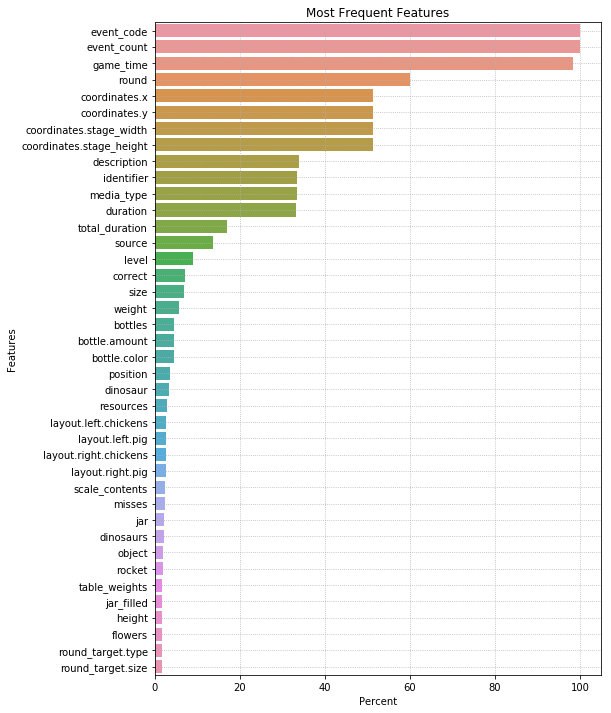

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 12))
ax = sns.barplot(x='Percent', y='index', data=stat_info.head(40))
ax.set_title('Most Frequent Features')
ax.set_ylabel('Features')
ax.grid(True, linestyle='dotted')

In [171]:
freq_keys = stat_info['index'][stat_info['Percent'] >= 5.].tolist()

In [172]:
freq_keys

['event_code',
 'event_count',
 'game_time',
 'round',
 'coordinates.x',
 'coordinates.y',
 'coordinates.stage_width',
 'coordinates.stage_height',
 'description',
 'identifier',
 'media_type',
 'duration',
 'total_duration',
 'source',
 'level',
 'correct',
 'size',
 'weight']

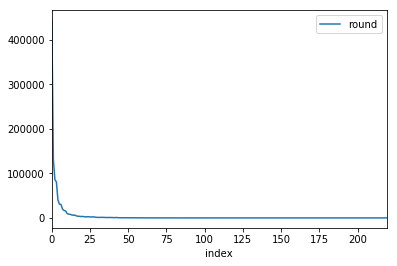

In [246]:
round_df = event_data['round'].fillna(0).value_counts().reset_index()
round_df['index'] = round_df['index'].astype(int)
round_df.sort_values(by='index', inplace=True)
round_df.plot(x='index', y='round')

In [251]:
np.isnan(event_data['coordinates.x'].iloc[3])

True

In [248]:
event_data['coordinates.x'].fillna(0)

0         954.0
1         393.0
2           0.0
3           0.0
4           0.0
          ...  
999995    910.0
999996    752.0
999997    646.0
999998      0.0
999999    337.0
Name: coordinates.x, Length: 1000000, dtype: float64

In [266]:
event_data['media_type'].fillna('unknown').value_counts()

unknown      665828
animation    222336
audio        111836
Name: media_type, dtype: int64

In [234]:
# round: float with NaNs
# coordinates.(x|y): float with NaNs, but presumably integer
# coordinates.stage_(width|height): float with NaNs, but presumably categorical
#
# description: text messages, try to convert into categoricals?
#     (event_data['description'].fillna('n/a').value_counts()
#      .rename('count').reset_index().rename(columns={'index': 'text'}))
#
# identifier: some string, probably concatenated with commas; most simple is to compute len
# event_data['identifier'].fillna('n/a').str.split(',').apply(len)
#
# media_type: categorical string
# event_data['media_type'].fillna('n/a').value_counts()
#
# duration: should already exist in the features set
# total_duration: probably also present in the features
#
# source: also some kind of categorical string
# event_data['source'].fillna('n/a').value_counts()
#
# level: integer feature, can be used as a cumulative metric (?)
# event_data['level'].fillna('n/a').value_counts()
#
# correct: defines if attempt was done, is already used in feature processing
# 
# size: integer feature
# event_data['size'].fillna('n/a').value_counts()
#
# weight: one more integer feature
# event_data['weight'].fillna('n/a').value_counts()

## Features Selection

In [21]:
selector = selection.FeatureSelection(
    rules=[
        ('nonzero', selection.non_zero_rows_and_cols),
        # ('uncorr', selection.non_correlated_cols),
    ],
    ignore_cols=[
        'accuracy_group', 
        'installation_id', 
        'game_session'
    ]
)

if U.on_kaggle():
    U.log('Loading relevant features list from disk.')
    features = bundle.features()
else:
    U.log('Deriving relevant features from train dataset.')
    features = selector.select(X_trn)
    bundle.save(features, 'features')

Deriving relevant features from train dataset.
Excluding from consideration: ['accuracy_group', 'installation_id', 'game_session']
Applying feature selection rule: nonzero
Selected features: 935 of 950
Keeping only features, selected by every rule.
Final number of features changed from 950 to 935


## Submission

In [ ]:
algo = 'lightgbm_random'
version = '014'
features =  cnt_cols + perf_cols + user_cols + event_cols + var_cols

if U.on_kaggle():
    U.log('Inference on Kaggle.')
    features = bundle.features()
    bounds = bundle.bounds()
    predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
    U.log('Saving predictions on disk.')
    filename = submit(predicted)
    submit_df = pd.read_csv(filename)
    U.log('First 20 submission rows:')
    display(submit_df.head(20))
    
else:
    U.log('Training with sub-optimal rounding.')
    reg_metric = RegressionCappa([-np.inf, 1., 2., 3., +np.inf])
    result = train(X_trn, features, reg_metric, algo=algo)
    
    U.log('Using predictions to find optimal rounding boundaries.')
    opt_bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
    U.log(f'Optimal values: {opt_bounds}')
    
    U.log('Using optimal boundaries to train a new ensemble of models.')
    reg_metric = RegressionCappa(opt_bounds)
    result = train(X_trn, features, reg_metric, algo=algo)
    
    U.log('Saving the final results.')
    bundle.save(result.models, f'models_{algo}_{version}')
    bundle.save(opt_bounds, 'bounds')

In [23]:
if not U.on_kaggle():
    import os
    features = bundle.features()
    bounds = bundle.bounds()
    filename = submit(inference(X_tst, features, bounds, model=algo, version=version))
    assert os.path.exists(filename)
    assert pd.read_csv(filename).shape[0] == 1000
    bundle.package(folder='/home/ck/data/bowl2019/external/')

Running inference on dataset of shape: 935
Loading external models: lightgbm v013.
Running models on test data...
Averaging ensemble predictions.
Rounding predictions using optimal bounds.
Converting predictions into submission file.
Running locally.
(1000, 2) Packaging training results into dataset.
/tmp/bowl2019/meta.joblib --> /home/ck/data/bowl2019/external/meta.joblib
/tmp/bowl2019/models_lightgbm_012.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_012.joblib
/tmp/bowl2019/bounds.joblib --> /home/ck/data/bowl2019/external/bounds.joblib
/tmp/bowl2019/models_lightgbm_013.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_013.joblib
/tmp/bowl2019/models_lightgbm_010.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_010.joblib
/tmp/bowl2019/features.joblib --> /home/ck/data/bowl2019/external/features.joblib
/tmp/bowl2019/encoders.joblib --> /home/ck/data/bowl2019/external/encoders.joblib
/tmp/bowl2019/models_lightgbm_011.joblib --> /home/ck/data/bowl2019/ex